<a href="https://colab.research.google.com/github/SivalayaG/BioInf/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import halfnorm
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils._testing import ignore_warnings
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Obtain and clean our final train data

train_data = pd.read_csv('/content/drive/MyDrive/trainset2.csv')
train_data

,component1,component2,y
0,0.005477,-0.001006,1
1,0.204483,0.044904,1
2,-0.087482,0.021875,1
3,0.034319,-0.122092,1
4,0.039086,0.013469,1
...,...,...,...
587,0.172334,0.213057,1
588,-0.015920,-0.062548,1
589,0.263756,0.690210,1
590,0.218608,0.029319,1


In [ ]:
## We have 533 tumor genes data and 59 normal genes data

train_data.y.value_counts()

1    533
0     59
Name: y, dtype: int64

In [ ]:
## Create x and y separately from out train data

x = train_data.drop(['y'], axis = 1, inplace = False).to_numpy()
y = train_data[['y']].to_numpy()

x.shape, y.shape

((592, 2), (592, 1))

In [ ]:
## We split our data into train and test split by 80/20 ratio

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, stratify=y, test_size=0.20)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((473, 2), (473, 1), (119, 2), (119, 1))

In [ ]:
## We verify the stratified sampling in our test data 
## by checking number of tumors vs non-tumors

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0  12]
 [  1 107]]


In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

def val_acc_class_report_error_analysis(name, model, val_x, val_y, accuracy_only=False):
    pred_y  = model.predict(val_x)
    cm = confusion_matrix(val_y, pred_y)
    print('Model: {}'.format(name))
    
    ### Use the confusion matrix to compute (using NumPy) the accuracy (call the result 'val_acc')

    val_acc = (cm.trace()) / cm.sum()
    
    print('--- Validation accuracy: {: .2f}%\n'.format(val_acc*100))
    
    if accuracy_only:
        return
    
    classes = [str(d) for d in range(0, 10)]
    print('--- Classification Report: ')
    
    ### Print the classification report with 3 digits of precision
    
    print(classification_report(val_y, pred_y, digits=3))
          
    # fig = plt.figure(figsize=(10,8))
    # ax = plt.gca()
    # note: depending on your sklearn version, you may get a warning/error because `plot_confusion_matrix` is deprecated
    # if so, you should use ConfusionMatrixDisplay instead and fix the code so it plots the confusion matrix
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

In [ ]:
## Define our model and hyperparameters' range to tune for getting bext model

param_dist = dict(hidden_layer_sizes=[x for x in range(50,201,10)], activation=['identity', 'logistic', 'tanh', 'relu'], solver=['lbfgs', 'sgd', 'adam'], learning_rate=['constant', 'invscaling', 'adaptive'])
model = MLPClassifier(max_iter=5000,early_stopping=True,random_state=42)

param_dist

{'hidden_layer_sizes': [50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200],
 'activation': ['identity', 'logistic', 'tanh', 'relu'],
 'solver': ['lbfgs', 'sgd', 'adam'],
 'learning_rate': ['constant', 'invscaling', 'adaptive']}

In [ ]:
## Train our model using RandomizedSearchCV with 10 kfold for cross validation


@ignore_warnings()
def do_randomized_search(model, param_dist):
    # RandomizedSearchCV class of scikit-learn to do a randomized search (use 'model')
    # We compute accuracy as scoring function and return the result of fit() on the training data 
    
    rs_cv = RandomizedSearchCV(model, param_distributions=param_dist, scoring='accuracy', cv = 10, random_state=42)
    return rs_cv.fit(train_x, train_y)

# Print best hyperparameters
rs_res = do_randomized_search(model, param_dist)
rs_res.best_params_

{'solver': 'lbfgs',
 'learning_rate': 'invscaling',
 'hidden_layer_sizes': 120,
 'activation': 'relu'}

Model: Multi-layer Perceptron Classifier
--- Validation accuracy:  94.12%

--- Classification Report: 
              precision    recall  f1-score   support

           0      0.667     0.833     0.741        12
           1      0.981     0.953     0.967       107

    accuracy                          0.941       119
   macro avg      0.824     0.893     0.854       119
weighted avg      0.949     0.941     0.944       119



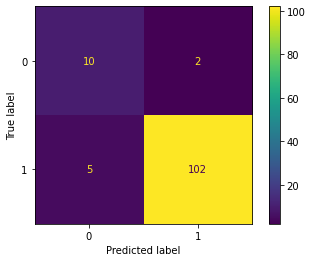

In [ ]:
## Print accuracy and classification report to analyze results

best_model = rs_res.best_estimator_
val_acc_class_report_error_analysis("Multi-layer Perceptron Classifier", best_model, test_x, test_y)

In [ ]:
rs_res.best_score_

0.9469858156028368